### Importing Libaries ###

In [53]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import warnings
import numpy as np
from numpy import array
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

warnings.filterwarnings("ignore")
#Notebook arguments
%matplotlib inline

# Importing Data

In [54]:
#I'm using pandas to download my data into the notebook
index_df = pd.read_pickle('vix.pickle')

In [55]:
index_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
1,2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2,2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
3,2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
4,2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [56]:
index_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2020-06-17,33.279999,35.169998,32.250000,33.470001,33.470001,0
2514,2020-06-18,33.830002,36.250000,32.240002,32.939999,32.939999,0
2515,2020-06-19,32.070000,35.119999,30.400000,35.119999,35.119999,0
2516,2020-06-22,35.220001,35.389999,31.639999,31.770000,31.770000,0
2517,2020-06-23,31.709999,31.709999,29.260000,31.370001,31.370001,0


In [57]:

type(index_df['Date'][2])

str

In [58]:
#Set the format of the date to datetime 
index_df['Date'] = pd.to_datetime(index_df['Date'])
#Set date column as index 
index_df = index_df.set_index(['Date'])

In [59]:
#I chose to train my model on 10 years of data
training = index_df['2010-06-23':'2020-06-01'].copy()
training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [60]:
#I chose to test my model's performance on data from 1st June 2020
testing = index_df['2020-06-01':].copy()
testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,28.940001,30.60,28.110001,28.230000,28.230000,0
2020-06-02,28.400000,28.52,26.660000,26.840000,26.840000,0
2020-06-03,26.750000,26.98,25.040001,25.660000,25.660000,0
2020-06-04,26.230000,26.43,24.379999,25.809999,25.809999,0
2020-06-05,24.790001,25.09,23.540001,24.520000,24.520000,0


In [61]:
#dropping Volume 
train = training.drop(['Volume'],axis = 1)

In [62]:
#scaling the data to pass it through the model 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train

array([[0.24321389, 0.25262603, 0.29089144, 0.24160434, 0.24160434],
       [0.252443  , 0.27521008, 0.30690827, 0.28008157, 0.28008157],
       [0.27999455, 0.27704832, 0.3156447 , 0.26363019, 0.26363019],
       ...,
       [0.25529315, 0.27022057, 0.30529039, 0.26444595, 0.26444595],
       [0.27538   , 0.27376575, 0.3030254 , 0.24976206, 0.24976206],
       [0.27049403, 0.27954306, 0.31629186, 0.25955132, 0.25955132]])

In [63]:
#Creating two empty lists that will be used to create training variables 
X_train = []
y_train = []

In [64]:
# Creating loop that iteratetes through the df and grabbes next sets of 30 days of values. 
#Use these sets to predict 1 day ahead.
for i in range(30,train.shape[0]):
    X_train.append(train[i-30:i])
    y_train.append(train[i,0])

In [65]:
# Turning X & Y trains into arrays for the model take it 
X_train,y_train = np.array(X_train), np.array(y_train)

In [66]:
#Sanity Check to see whether X & Y variables have the right shape
X_train.shape, y_train.shape

((2472, 30, 5), (2472,))

In [67]:
#Because this model uses the past 30 days to predict 1 day into the future we need to add the 60 days previous from 2018 to get the first day of 2019. 
#we are taking the last 30 days of our training data and making a new datafrane
past_30_days = training.tail(30)

In [68]:
#Here we are adding testing data to the df we just created and dropping the Adj Close column
dff = past_30_days.append(testing)
dff = dff.drop(['Volume'],axis = 1)
dff.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-04-20,40.680000,43.830002,39.880001,43.830002,43.830002
2020-04-21,44.279999,47.770000,43.770000,45.410000,45.410000
2020-04-22,44.910000,45.070000,41.410000,41.980000,41.980000
2020-04-23,41.299999,42.470001,39.060001,41.380001,41.380001
2020-04-24,38.799999,40.169998,35.599998,35.930000,35.930000


In [69]:
#Scaling the dataframe list created and turning it into an array 
inputs =scaler.transform(dff)
inputs

array([[0.42983169, 0.45325632, 0.50671412, 0.47165195, 0.47165195],
       [0.47869161, 0.50498949, 0.5696489 , 0.49313391, 0.49313391],
       [0.48724211, 0.46953781, 0.53146737, 0.44649897, 0.44649897],
       [0.43824645, 0.43539917, 0.49344765, 0.43834127, 0.43834127],
       [0.40431594, 0.40519955, 0.43746961, 0.364242  , 0.364242  ],
       [0.37024973, 0.35622372, 0.3874777 , 0.32834807, 0.32834807],
       [0.32844732, 0.34243696, 0.35560589, 0.33215499, 0.33215499],
       [0.31853962, 0.3135504 , 0.35835622, 0.3003399 , 0.3003399 ],
       [0.29831704, 0.3496586 , 0.36191553, 0.34004081, 0.34004081],
       [0.39576543, 0.39732142, 0.45348647, 0.38137319, 0.38137319],
       [0.40879479, 0.40716911, 0.43633712, 0.36478586, 0.36478586],
       [0.35029858, 0.35333509, 0.37841773, 0.33269885, 0.33269885],
       [0.32138977, 0.34637603, 0.37404949, 0.33963288, 0.33963288],
       [0.31365362, 0.30160187, 0.35285552, 0.30319511, 0.30319511],
       [0.28678065, 0.2767857 , 0.

In [70]:
#Repeating what we did earlier 
#first create two lists X and Y 
#then create a for loop that iteraterates through our df and grabbes sets of 30 days of values. 
#we are then going to use these sets to predict 1 day ahead.
X_test = []
y_test = []

for i in range(30, inputs.shape[0]):
    X_test.append(inputs[i-30:i])
    y_test.append(inputs[i,0])

In [71]:
# we are turning our X & Y tests into arrays for the model
X_test, y_test = np.array(X_test), np.array(y_test)

# Baseline Model 

In [72]:
#First initialize model 
model1 = Sequential()
#Then add  lstm layer - for base model I randomly inputed 60 units
model1.add(LSTM(units = 60, activation='relu', input_shape=(X_train.shape[1],5)))
#now we add out dense layer 
model1.add(Dense(1))

In [73]:
#Checking if model setup to specifications by using .summary()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                15840     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [74]:
#Compiled my model using adam optimization and mean_squared_error for loss 
model1.compile(optimizer='adam', loss = 'mean_squared_error')

In [75]:
#Fitting model using X and Y train, 10 epochs and a batch size of 200.
model1.fit(X_train,y_train,epochs=10,batch_size=200)

Epoch 1/10
13/13 [==============================] - 0s 20ms/step - loss: 0.0247
Epoch 2/10
13/13 [==============================] - 0s 20ms/step - loss: 0.0050
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 0.0022
Epoch 4/10
13/13 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 5/10
13/13 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 6/10
13/13 [==============================] - 0s 19ms/step - loss: 0.0010
Epoch 7/10
13/13 [==============================] - 0s 19ms/step - loss: 9.0822e-04
Epoch 8/10
13/13 [==============================] - 0s 19ms/step - loss: 8.2082e-04
Epoch 9/10
13/13 [==============================] - 0s 19ms/step - loss: 7.4025e-04
Epoch 10/10
13/13 [==============================] - 0s 19ms/step - loss: 6.9374e-04


In [76]:
#Now use fitted model and pass through X_test and predict y_test.
y_pred1 = model1.predict(X_test)

In [77]:
#checking output. We will need to scale data back to values for interpretation
y_pred1

array([[0.2509489 ],
       [0.25207517],
       [0.24782294],
       [0.2392227 ],
       [0.23188677],
       [0.22138155],
       [0.21792755],
       [0.22038856],
       [0.22459418],
       [0.26366165],
       [0.29806885],
       [0.32715407],
       [0.33217728],
       [0.33297345],
       [0.33365408],
       [0.3321827 ],
       [0.33031145]], dtype=float32)

In [78]:
#using .scale_ on our scaler, take first value and use it to scale the pr 
scaler.scale_

array([0.0135722 , 0.01313025, 0.01617861, 0.01359619, 0.01359619])

In [79]:
# Here I am setting up my scale
scale = 1/0.0135722
scale

73.6800223987268

In [80]:
# This function should stream line scaling,graphing, and evaluation process
def ScaleGraphEval(y_pred,name):
    #this scales prediction to normal values 
    y_pred=y_pred*scale
    #now with normalized predictions one can graph them against actuals  
    plt.figure(figsize=(18,5))
    plt.plot(y_test, color = 'b', label = 'Actual VIX Value')
    plt.plot(y_pred ,color ='r', label = 'Predicted VIX Value')
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('VIX Index Prediction')
    plt.legend()
    plt.show()
    # Calculating the RMSE and display it at the bottom
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print('The RMSE of this Model is',rmse)

In [81]:
#Scaling y_test data back to normal.
y_test = y_test*scale

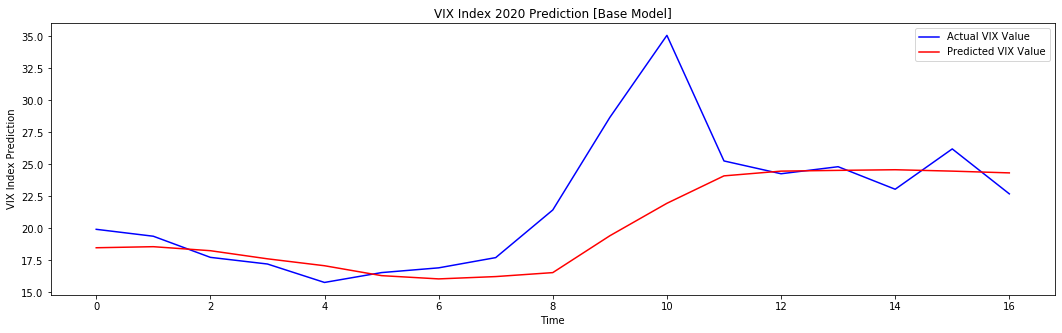

The RMSE of this Model is 4.192658494668473


In [82]:
ScaleGraphEval(y_pred1,'VIX Index 2020 Prediction [Base Model]')

# Model 2 

In [83]:

# This is my second model
model2 = Sequential()
# After some trials I found that setting my units to 110 gets me the best rmse score 
model2.add(LSTM(units = 110, activation='relu', input_shape=(X_train.shape[1],5)))

model2.add(Dense(1))

In [84]:

#Here I see that my model is set up properly 
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 110)               51040     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 111       
Total params: 51,151
Trainable params: 51,151
Non-trainable params: 0
_________________________________________________________________


In [85]:
model2.compile(optimizer='adam', loss = 'mean_squared_error')
# After a few trials I found that increaseing my epochs to 80 and reducing my batch size to 50 gave me a lower rmse 
model2.fit(X_train,y_train,epochs=80,batch_size=50)

Epoch 1/80
50/50 [==============================] - 1s 13ms/step - loss: 0.0055
Epoch 2/80
50/50 [==============================] - 1s 13ms/step - loss: 8.0297e-04
Epoch 3/80
50/50 [==============================] - 1s 13ms/step - loss: 6.8760e-04
Epoch 4/80
50/50 [==============================] - 1s 13ms/step - loss: 5.8650e-04
Epoch 5/80
50/50 [==============================] - 1s 13ms/step - loss: 5.0676e-04
Epoch 6/80
50/50 [==============================] - 1s 13ms/step - loss: 4.7238e-04
Epoch 7/80
50/50 [==============================] - 1s 13ms/step - loss: 4.2575e-04
Epoch 8/80
50/50 [==============================] - 1s 13ms/step - loss: 3.8649e-04
Epoch 9/80
50/50 [==============================] - 1s 13ms/step - loss: 4.0303e-04
Epoch 10/80
50/50 [==============================] - 1s 13ms/step - loss: 3.5289e-04
Epoch 11/80
50/50 [==============================] - 1s 13ms/step - loss: 3.0952e-04
Epoch 12/80
50/50 [==============================] - 1s 13ms/step - loss: 3.26

In [87]:
y_pred2 = model2.predict(X_test)
y_pred2

array([[0.27066427],
       [0.26803184],
       [0.24611877],
       [0.2293648 ],
       [0.22958381],
       [0.21120194],
       [0.23110576],
       [0.25356185],
       [0.25420913],
       [0.4160551 ],
       [0.36492446],
       [0.36509565],
       [0.3469643 ],
       [0.3394318 ],
       [0.33580813],
       [0.3560135 ],
       [0.31388196]], dtype=float32)

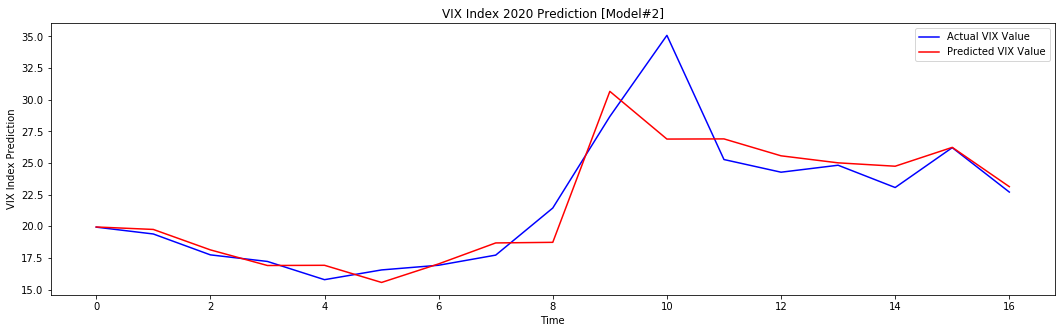

The RMSE of this Model is 2.2928526851777185


In [88]:
ScaleGraphEval(y_pred2,'VIX Index 2020 Prediction [Model#2]')
#Here we got an RMSE of 2.28 though I suspect that there is an over fitting problem

# Model 3 

In [90]:
model3 = Sequential()
#In this model I am adding a second layer to see how the results vary 
model3.add(LSTM(units = 110, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
model3.add(Dropout(0.2))
#After some experimination and research I found that lowering the number of units in my second layer increases performance 
model3.add(LSTM(units = 80, activation='relu'))
model3.add(Dropout(0.2))
#I added droupout of .2 to each layer to solve my overfitting problem 
model3.add(Dense(1))

In [91]:
# checking if model is set up exactly to specifications 
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 110)           51040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 110)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 80)                61120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 81        
Total params: 112,241
Trainable params: 112,241
Non-trainable params: 0
_________________________________________________________________


In [92]:
model3.compile(optimizer='adam', loss = 'mean_squared_error')

model3.fit(X_train,y_train,epochs=80,batch_size=50)

Epoch 1/80
50/50 [==============================] - 1s 26ms/step - loss: 0.0033
Epoch 2/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0015
Epoch 3/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0013
Epoch 4/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0012
Epoch 5/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0011
Epoch 6/80
50/50 [==============================] - 1s 24ms/step - loss: 9.3294e-04
Epoch 7/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0010
Epoch 8/80
50/50 [==============================] - 1s 24ms/step - loss: 9.0833e-04
Epoch 9/80
50/50 [==============================] - 1s 24ms/step - loss: 8.9538e-04
Epoch 10/80
50/50 [==============================] - 1s 26ms/step - loss: 8.5653e-04
Epoch 11/80
50/50 [==============================] - 1s 25ms/step - loss: 7.5023e-04
Epoch 12/80
50/50 [==============================] - 1s 25ms/step - loss: 7.5352e-04
Epoch 13/80
5

In [93]:
y_pred3 = model3.predict(X_test)

y_pred3

array([[0.26279128],
       [0.25843048],
       [0.24311715],
       [0.22834148],
       [0.22664535],
       [0.20999976],
       [0.22571911],
       [0.24091795],
       [0.24445283],
       [0.40253216],
       [0.3517034 ],
       [0.3610142 ],
       [0.32545465],
       [0.32964563],
       [0.31975424],
       [0.3368494 ],
       [0.3097229 ]], dtype=float32)

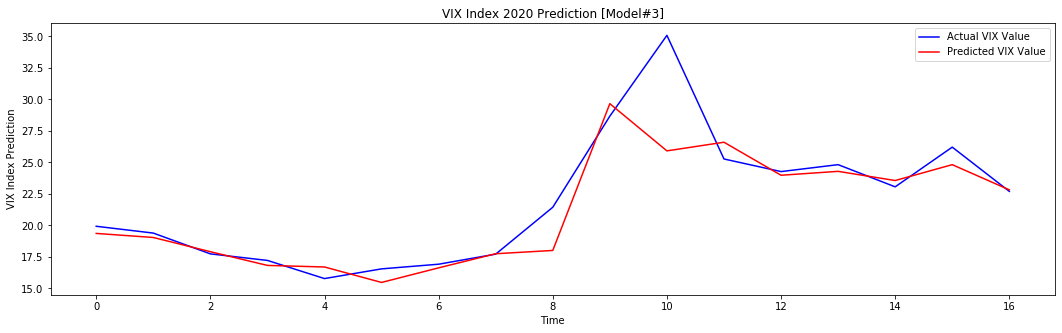

The RMSE of this Model is 2.47114682775307


In [94]:

ScaleGraphEval(y_pred3,'VIX Index 2020 Prediction [Model#3]')

# Final Model

In [96]:
regressor = Sequential()
#tried a third layer to improve results 
regressor.add(LSTM(units = 150, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
regressor.add(Dropout(0.15))
#kept decreasing units at ever layer
regressor.add(LSTM(units = 100, activation='relu',return_sequences = True))
regressor.add(Dropout(0.15))
#added a dropout of .15 to each layer 
regressor.add(LSTM(units = 80, activation='relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(1))

In [102]:
#check model is set up to specifications 
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 150)           93600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 150)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 30, 100)           100400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 80)                57920     
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [103]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')

In [99]:
regressor.fit(X_train,y_train,epochs=180,batch_size=50)

Epoch 1/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0047
Epoch 2/180
50/50 [==============================] - 2s 40ms/step - loss: 0.0022
Epoch 3/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0017
Epoch 4/180
50/50 [==============================] - 2s 42ms/step - loss: 0.0014
Epoch 5/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0013
Epoch 6/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0015
Epoch 7/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0013
Epoch 8/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0010
Epoch 9/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0010
Epoch 10/180
50/50 [==============================] - 2s 41ms/step - loss: 9.2129e-04
Epoch 11/180
50/50 [==============================] - 2s 42ms/step - loss: 9.1736e-04
Epoch 12/180
50/50 [==============================] - 2s 41ms/step - loss: 9.0664e-04
Epoch 13/180


50/50 [==============================] - 2s 40ms/step - loss: 3.1694e-04
Epoch 97/180
50/50 [==============================] - 2s 40ms/step - loss: 3.3378e-04
Epoch 98/180
50/50 [==============================] - 2s 41ms/step - loss: 2.9439e-04
Epoch 99/180
50/50 [==============================] - 2s 40ms/step - loss: 3.6745e-04
Epoch 100/180
50/50 [==============================] - 2s 40ms/step - loss: 4.0117e-04
Epoch 101/180
50/50 [==============================] - 2s 40ms/step - loss: 3.5569e-04
Epoch 102/180
50/50 [==============================] - 2s 40ms/step - loss: 3.1123e-04
Epoch 103/180
50/50 [==============================] - 2s 40ms/step - loss: 3.2950e-04
Epoch 104/180
50/50 [==============================] - 2s 40ms/step - loss: 3.2949e-04
Epoch 105/180
50/50 [==============================] - 2s 40ms/step - loss: 3.1767e-04
Epoch 106/180
50/50 [==============================] - 2s 40ms/step - loss: 3.4475e-04
Epoch 107/180
50/50 [==============================] - 2s 40

In [100]:
y_pred4 = regressor.predict(X_test)

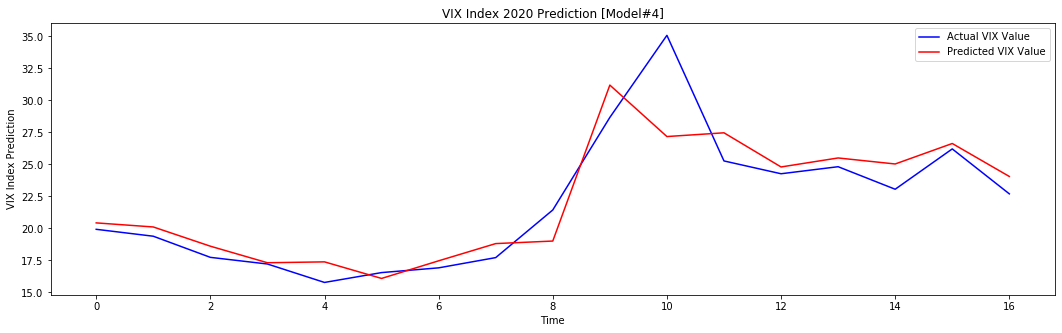

The RMSE of this Model is 2.327287048583684


In [101]:
ScaleGraphEval(y_pred4,'VIX Index 2020 Prediction [Model#4]')
#evaluating final model

# Model 2 was the best performing LSTM 